In [9]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility import *
from mkit.torch_support.nn_utils import training_loop
import torch
from torch import nn

In [3]:
import matplotlib.pyplot as plt

In [4]:
files = get_files("../Travel-Itinerary-Datasets-for-Japan-and-Taiwan-sourced-from-Ptt")
return_list = []
file = files[0]
path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']
WIDTH, HEIGHT

original dataset size: 238
dataset size with duplicates removed: 172


(48, 64)

In [5]:
x_list = []
y_list = []
y_seq_list = []
y_one_hot_list = []
for observation in labels:
    unique_values = np.unique(observation)[1:]
    if len(unique_values) == 1: continue
    unique_values = np.sort(unique_values)

    half = len(unique_values) // 2
    x = deepcopy(observation)
    y = deepcopy(observation)
    y_seq = []
    y_one_hot = deepcopy(observation)
    y_one_hot[np.where(y_one_hot != 0)] = 1
    for val in unique_values:
        index = np.where(observation == val)
        coor = encoder.single_transform(tuple([index[0][0], index[1][0]]))
        if val > half:
            x[index] = 0
            y_seq.append(coor)
            
        else:
            x[index] = 1
            y_one_hot[index] = 0
            y[index] = 0
    y = y / max(unique_values)
    y_seq += [0] * (MAX_LEN - len(y_seq))

    y_one_hot = y_one_hot.flatten()
    x_list.append(x)
    y_list.append(y)
    y_one_hot_list.append(y_one_hot)
    y_seq_list.append(y_seq)
    

In [6]:
from mkit.torch_support.tensor_utils import xy_to_tensordataset
loader, val_loader, test_loader = xy_to_tensordataset(
    np.expand_dims(np.array(x_list), 1), np.array(y_one_hot_list),
    return_loader=True, 
    batch_size=8,
    input_dtype=torch.float32,
    output_dtype=torch.float32,
    val_ratio=.15,
    test_ratio=.15
)

In [14]:
x, y = next(iter(test_loader))
embedings = nn.ModuleList()
for i in range(WIDTH * HEIGHT):
    embedings.append(nn.Embedding(MAX_LEN, 16))

value = []
for idx, element in enumerate(x.view(x.size(0), 1, -1)):
    value.append(embedings[idx](element.long()))



In [ ]:
torch.concat(value)


torch.Size([1, 3072, 16])

In [ ]:

class CNN(nn.Module):
    def __init__(
            self, 
            width,
            height,
            input_dim=1, 
            start_dim=4,
            number_of_layers = 2,
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        ):
        super(CNN, self).__init__()
        self.encoder = [self._block(input_dim, start_dim)]
        current_dim = start_dim
        for i in range(number_of_layers - 1):
            self.encoder.append(self._block(current_dim, current_dim * 2))
            current_dim *= 2
        self.encoder.append(nn.Flatten())
        self.encoder = nn.Sequential(*self.encoder)
        
        self.out_fc = nn.Linear(width * height * current_dim, width * height)
        self.to(device)
        self.device = device
    def _block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Conv2d(input_dim, output_dim, padding=1, kernel_size=3),
            nn.BatchNorm2d(output_dim),
            nn.LeakyReLU(.2)
        )
    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder(x)
        x = self.out_fc(x)
        return x
    
cnn = CNN(width=WIDTH, height=HEIGHT)
model, train_losses, val_losses = training_loop(
    model=cnn,
    train_loader=loader,
    val_loader=val_loader,
    epochs=20,
    device=cnn.device,
    criterion=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.Adam(cnn.parameters(), lr=1e-3),
    keep_losses=True
)



C:\Users\ss348\AppData\Local\Temp\ipykernel_6996\2287573786.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


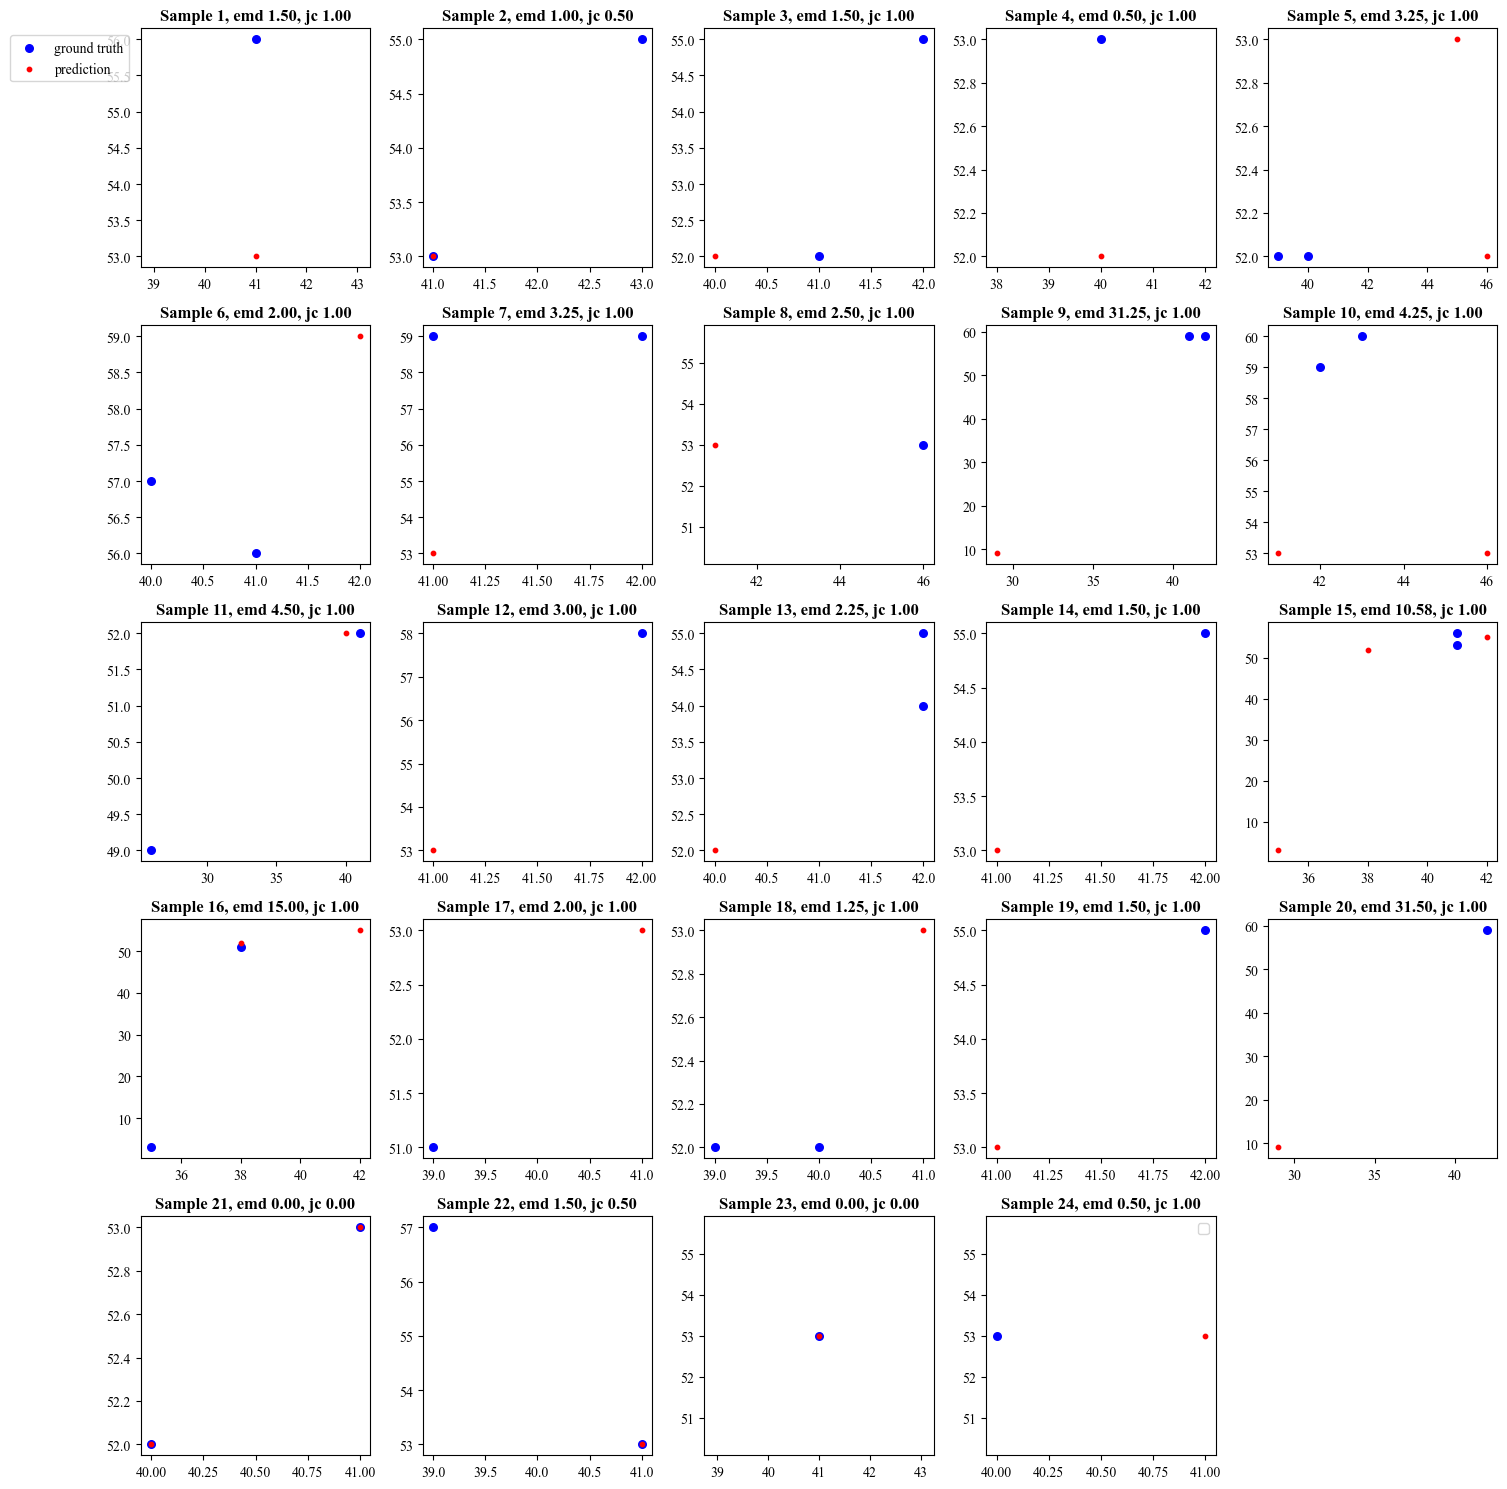

In [9]:

from scipy.stats import wasserstein_distance

def jaccard_sim(pred, truth):
    pred_set = set(pred)
    truth_set = set(truth)
    return len(pred_set & truth_set) / len(pred_set | truth_set)

plt.rcParams["font.family"] = "Times New Roman"
jc_list = []
emd_list = []
total_number_of_samples = test_loader.dataset.__len__()
cols = 5
rows = (total_number_of_samples // cols) + 1
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

axes = axes.flatten()

for i, (test_x, test_y) in enumerate(test_loader.dataset):
    ax = axes[i]
    test_x = test_x.to(cnn.device)
    test_x = test_x.unsqueeze(0)
    truth = np.argwhere(test_y != 0)[0].detach().numpy()

    raw_pred = cnn(test_x)[0]
    pred = torch.argwhere(raw_pred > .5).squeeze(1)
    if len(pred) == 0:
        pred = torch.argmax(raw_pred).unsqueeze(0)
    pred = pred.cpu().detach().numpy()
    
    jc_score = 1- jaccard_sim(pred, truth)

    pred = encoder.transform(pred, inverse=True)
    truth = encoder.transform(truth, inverse=True)

    truth_np = np.array(truth)
    pred_np = np.array(pred)

    ax.scatter(truth_np[:, 0], truth_np[:, 1], c='blue', s=30
                , label='ground truth' if i ==0 else None)
    ax.scatter(pred_np[:, 0], pred_np[:, 1], c='red', s=10, 
                label='prediction' if i ==0 else None)
    emd_x = wasserstein_distance(pred_np[:, 0], truth_np[:, 0])
    emd_y = wasserstein_distance(pred_np[:, 1], truth_np[:, 1])
    emd = (emd_x + emd_y) / 2
    ax.set_title(f"Sample {i+1}, emd {emd:.2f}, jc {jc_score:.2f}", 
                 fontsize=12, fontweight='bold')
    jc_list.append(jc_score)
    emd_list.append(emd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
if total_number_of_samples > 0:
    axes[0].legend(loc='upper left', bbox_to_anchor=(-.6, 1))
plt.tight_layout()
plt.legend()

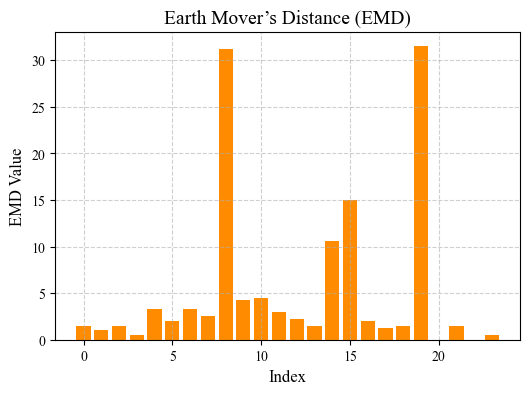

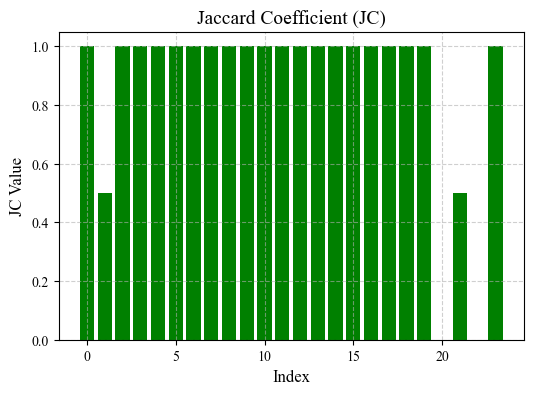

In [10]:
import matplotlib.pyplot as plt

# Increase figure size for readability
plt.figure(figsize=(6, 4))
plt.bar(range(len(emd_list)), emd_list, color='darkorange')
plt.xlabel('Index', fontsize=12)
plt.ylabel('EMD Value', fontsize=12)
plt.title('Earth Mover’s Distance (EMD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6) # Save as a high-resolution image
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(range(len(jc_list)), jc_list, color='g')
plt.xlabel('Index', fontsize=12)
plt.ylabel('JC Value', fontsize=12)
plt.title('Jaccard Coefficient (JC)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6) # Save as a high-resolution image
plt.show()
